In [1]:
import os
import numpy as np
import pandas as pd
import fastparquet
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gc


from joblib import Parallel, delayed
from scipy.stats import kurtosis
import category_encoders as ce


from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
import optuna

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = r'C:\Users\asus\Desktop\Stock-Volatility-Prediction-\optiver-realized-volatility-prediction'

In [3]:
book_train_raw = pd.read_parquet(f'{DATA_DIR}/book_train.parquet/stock_id=0')
book_train_raw

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28


In [4]:
trade_train_raw = pd.read_parquet(f"{DATA_DIR}/trade_train.parquet/stock_id=0")
trade_train_raw

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
...,...,...,...,...,...
123438,32767,471,0.998659,200,3
123439,32767,517,0.998515,90,1
123440,32767,523,0.998563,1,1
123441,32767,542,0.998803,90,4


Text(0, 0.5, 'Price')

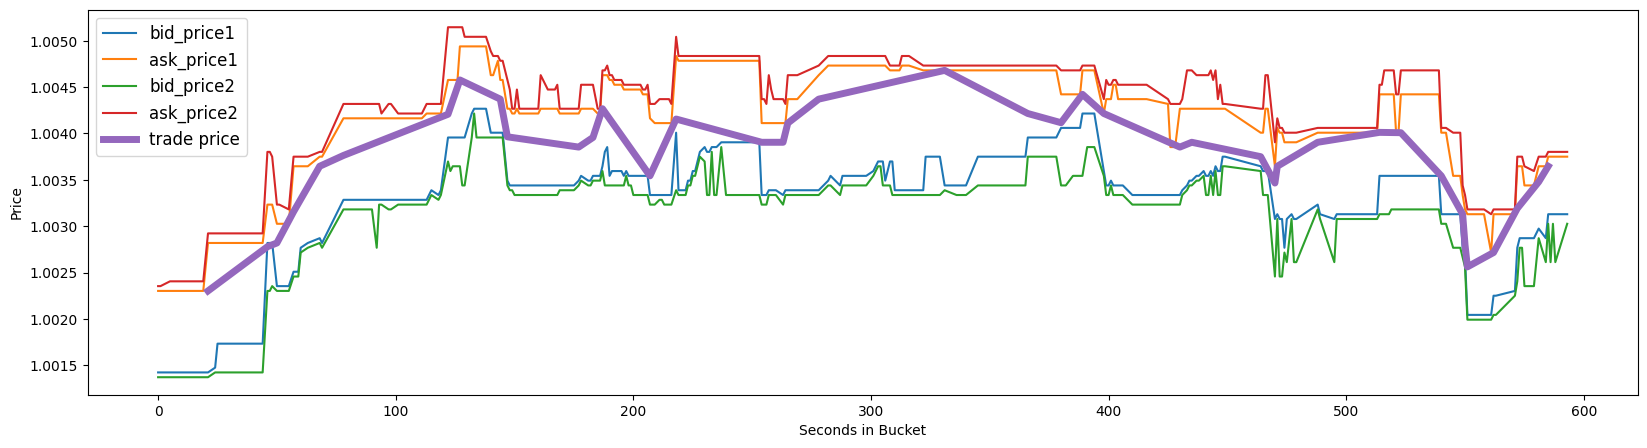

In [5]:
book_to_plot = book_train_raw.loc[book_train_raw.time_id==5]
trade_to_plot = trade_train_raw.loc[trade_train_raw.time_id==5]

samples = ['bid_price1', 'ask_price1','bid_price2', 'ask_price2']
plt.figure(figsize=(20,5))
for feature in samples: 
    plt.plot(book_to_plot["seconds_in_bucket"], book_to_plot[feature], label=feature)
plt.plot(trade_to_plot["seconds_in_bucket"],trade_to_plot["price"], label="trade price", lw=5)
plt.legend(fontsize=12)
plt.xlabel("Seconds in Bucket")
plt.ylabel("Price")

In [6]:
df_train_raw = pd.read_csv(f'{DATA_DIR}/train.csv')
df_test_raw = pd.read_csv(f'{DATA_DIR}/test.csv')
sample_submission = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')

In [7]:
df_train_raw

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


In [8]:
df_test_raw

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [9]:
sample_submission

,row_id,target
0,0-4,0.003048
1,0-32,0.003048
2,0-34,0.003048


In [10]:
stock_ids = set(df_train_raw['stock_id'])

In [11]:
def calc_log_ret(prices):
    x = np.log(prices)
    return np.diff(x, prepend=[x[0]])

In [12]:
def book_preprocess(file_path):
    
    df = pd.read_parquet(file_path)
    
    # Weighted Average Prices (WAP1 & WAP2)
    df['wap1'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['wap2'] = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    
    # Log Returns for WAP1 and WAP2
    df['log_ret1'] = df.groupby('time_id')['wap1'].transform(lambda x: calc_log_ret(x.to_numpy()))
    df['log_ret2'] = df.groupby('time_id')['wap2'].transform(lambda x: calc_log_ret(x.to_numpy()))
    
    # WAP Balance
    df['wap_balance'] = df['wap1'] - df['wap2']
    
    # Price Spread, Bid Spread, Ask Spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    
    # Total Volume and Volume Imbalance
    df['total_volume'] = df['ask_size1'] + df['ask_size2'] + df['bid_size1'] + df['bid_size2']
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Mid Price Change
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['mid_price_change'] = df.groupby('time_id')['mid_price'].transform(lambda x: x.diff())
    
    
    df['avg_bid_ask_spread'] = (df['ask_price1'] - df['bid_price1']) / (df['ask_price1'] + df['bid_price1'])
    df['bid_ask_spread_volatility'] = df.groupby('time_id')['avg_bid_ask_spread'].transform('std')

    # Rolling Volatility for WAP1 and WAP2
    df['rolling_volatility_wap1'] = df.groupby('time_id')['log_ret1'].transform(lambda x: x.rolling(window=30).std())
    df['rolling_volatility_wap2'] = df.groupby('time_id')['log_ret2'].transform(lambda x: x.rolling(window=30).std())
    
    # Liquidity Measures - Depth Ratio
    df['depth_ratio'] = (df['bid_size1'] + df['bid_size2']) / (df['ask_size1'] + df['ask_size2'])
    
    # Skewness and Kurtosis
    df['log_ret1_skew'] = df.groupby('time_id')['log_ret1'].transform('skew')
    df['log_ret2_skew'] = df.groupby('time_id')['log_ret2'].transform('skew')
    
    df['price_spread_skew'] = df.groupby('time_id')['price_spread'].transform('skew')
    df['volume_imbalance_skew'] = df.groupby('time_id')['volume_imbalance'].transform('skew')
    
    df['log_ret1_kurtosis'] = df.groupby('time_id')['log_ret1'].transform(lambda x: kurtosis(x, fisher=False))
    df['log_ret2_kurtosis'] = df.groupby('time_id')['log_ret2'].transform(lambda x: kurtosis(x, fisher=False))  # Unbiased kurtosis
    
    # VWAP Calculation
    df['vwap'] = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    
    # Create the Feature Aggregation Dictionary
    create_feature_dict = {
        'wap1': ['mean', 'std'],
        'wap2': ['mean', 'std'], 
        'log_ret1': ['std'],
        'log_ret2': ['std'],
        'wap_balance': ['mean', 'std'],
        'price_spread': ['mean', 'std'],
        'bid_spread': ['mean', 'std'],
        'ask_spread': ['mean', 'std'],
        'volume_imbalance': ['mean', 'std'],
        'total_volume': ['mean', 'std'],
        'depth_ratio':['mean', 'std'],
        'vwap':['mean', "std"],
        'rolling_volatility_wap2':["mean", "std"],
        'rolling_volatility_wap1':["mean", "std"],
        'log_ret1_skew':["mean"],
        'log_ret2_skew':['mean'],
        'volume_imbalance_skew':['mean'],
        'price_spread_skew':['mean'],
        'log_ret1_kurtosis':['mean'],
        'log_ret2_kurtosis':['mean']
        }
    
       # Feature Aggregation
    df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    
    # Flatten Columns
    df_feature.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature.columns]
    
    # Additional Features for Last 300s, 120s
    last_seconds = [300, 120]
    for second in last_seconds:
        df_feature_sec = pd.DataFrame(df[df['seconds_in_bucket'] >= 600 - second]).groupby(['time_id']).agg(create_feature_dict).reset_index()
        df_feature_sec.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix(f'_{second}')
        
        df_feature = pd.merge(df_feature, df_feature_sec, how='left', left_on='time_id',right_on=f'time_id_{second}')
        df_feature.drop([f'time_id_{second}'], axis=1, inplace=True)
    
    # Add Row ID
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = str(stock_id) + '-' + df_feature['time_id'].astype(str)
    df_feature.drop(['time_id'], axis=1, inplace=True)
    
    return df_feature


In [13]:
book_preprocess(f'{DATA_DIR}/book_train.parquet/stock_id=0')

,wap1_mean,wap1_std,wap2_mean,wap2_std,log_ret1_std,log_ret2_std,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,...,rolling_volatility_wap2_std_120,rolling_volatility_wap1_mean_120,rolling_volatility_wap1_std_120,log_ret1_skew_mean_120,log_ret2_skew_mean_120,volume_imbalance_skew_mean_120,price_spread_skew_mean_120,log_ret1_kurtosis_mean_120,log_ret2_kurtosis_mean_120,row_id
0,1.003725,0.000693,1.003661,0.000781,0.000259,0.000403,0.000065,0.000484,0.000852,0.000211,...,0.000106,0.000199,0.000031,0.333550,0.302634,0.973341,0.140945,5.404960,7.469052,0-5
1,1.000239,0.000262,1.000206,0.000272,0.000085,0.000175,0.000033,0.000261,0.000394,0.000157,...,0.000033,0.000084,0.000027,-1.106416,0.294099,0.752084,1.113890,14.439831,6.892627,0-11
2,0.999542,0.000864,0.999680,0.000862,0.000173,0.000351,-0.000138,0.000389,0.000725,0.000164,...,0.000061,0.000175,0.000019,-0.194037,-0.453121,0.838349,0.204095,9.278814,6.646224,0-16
3,0.998832,0.000757,0.998633,0.000656,0.000235,0.000333,0.000199,0.000409,0.000860,0.000280,...,0.000030,0.000281,0.000018,-1.974680,-1.368015,1.137728,0.339405,13.814140,8.661703,0-31
4,0.999619,0.000258,0.999626,0.000317,0.000143,0.000246,-0.000008,0.000317,0.000397,0.000130,...,0.000035,0.000179,0.000025,0.456073,0.118453,0.658649,0.609004,16.768414,5.519189,0-62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0.997938,0.000747,0.997864,0.000769,0.000150,0.000222,0.000074,0.000255,0.000552,0.000202,...,0.000052,0.000134,0.000030,-0.128195,0.136254,0.725062,0.778666,9.807566,5.909123,0-32751
3826,1.000310,0.000551,1.000487,0.000599,0.000154,0.000199,-0.000177,0.000278,0.000542,0.000147,...,0.000029,0.000174,0.000050,-0.957718,0.080282,0.890329,0.097520,14.379394,9.868262,0-32753
3827,0.999552,0.000743,0.999456,0.000736,0.000213,0.000239,0.000096,0.000288,0.000525,0.000244,...,0.000066,0.000181,0.000021,0.645792,-0.118480,1.554593,0.896227,6.270886,4.948925,0-32758
3828,1.002357,0.000356,1.002386,0.000424,0.000174,0.000292,-0.000029,0.000307,0.000480,0.000145,...,0.000043,0.000134,0.000027,-0.014441,-0.027242,0.615039,0.619148,6.587950,5.917373,0-32763


In [14]:
def trade_preprocess(file_path):
    df = pd.read_parquet(file_path)
    df['log_ret'] = df.groupby('time_id')['price'].transform(lambda x: calc_log_ret(x.to_numpy())) # Each time_id is a window having several time stamps
    
    aggregate_dictionary = {
        'log_ret': ['std'],
        'size': ['sum', 'mean', 'std'],
        'order_count': ['sum', 'mean', 'std'],
    }
    df_feature = df.groupby('time_id').agg(aggregate_dictionary).reset_index()
    df_feature.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature.columns]
    
    last_seconds = [300, 120]
    for second in last_seconds:
        df_feature_sec = pd.DataFrame(df[df['seconds_in_bucket'] >= 600 - second]).groupby(['time_id']).agg(aggregate_dictionary).reset_index()
        df_feature_sec.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix(f'_{second}')
        
        df_feature = pd.merge(df_feature, df_feature_sec,how='left', left_on='time_id',right_on=f'time_id_{second}')
        df_feature.drop([f'time_id_{second}'], axis=1, inplace=True)
    
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = str(stock_id) + '-' + df_feature['time_id'].astype(str)
    df_feature.drop(['time_id'], axis=1, inplace=True)
      
    return df_feature

In [15]:
trade_preprocess(f'{DATA_DIR}/trade_train.parquet/stock_id=0').head(5)

,log_ret_std,size_sum,size_mean,size_std,order_count_sum,order_count_mean,order_count_std,log_ret_std_300,size_sum_300,size_mean_300,...,order_count_mean_300,order_count_std_300,log_ret_std_120,size_sum_120,size_mean_120,size_std_120,order_count_sum_120,order_count_mean_120,order_count_std_120,row_id
0,0.000319,3179,79.475000,118.375107,110,2.750000,2.467741,0.000290,1587.0,75.571429,...,2.571429,2.292846,0.000314,739.0,67.181818,149.948537,27.0,2.454545,1.752920,0-5
1,0.000165,1289,42.966667,77.815203,57,1.900000,1.446756,0.000151,900.0,56.250000,...,2.250000,1.807392,0.000181,826.0,103.250000,111.347269,20.0,2.500000,2.267787,0-11
2,0.000387,2161,86.440000,113.587000,68,2.720000,2.300725,0.000275,1189.0,99.083333,...,3.166667,2.691175,0.000305,681.0,97.285714,112.658354,17.0,2.428571,1.812654,0-16
3,0.000387,1962,130.800000,144.828569,59,3.933333,4.043808,0.000381,1556.0,172.888889,...,5.111111,4.702245,0.000202,509.0,254.500000,276.478751,10.0,5.000000,4.242641,0-31
4,0.000190,1791,81.409091,117.914682,89,4.045455,4.099678,0.000143,1219.0,110.818182,...,4.909091,4.887833,0.000206,43.0,10.750000,15.585784,14.0,3.500000,4.358899,0-62


In [16]:
def preprocessor(stock_id_list, train_mode = True):
    
    from joblib import Parallel, delayed # parallel computing
    
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if train_mode:
            file_path_book = f'{DATA_DIR}/book_train.parquet/stock_id={stock_id}'
            file_path_trade = f'{DATA_DIR}/trade_train.parquet/stock_id={stock_id}'
        else:
            file_path_book = f'{DATA_DIR}/book_test.parquet/stock_id={stock_id}'
            file_path_trade = f'{DATA_DIR}/trade_test.parquet/stock_id={stock_id}'
            
        df_temp = pd.merge(book_preprocess(file_path_book), trade_preprocess(file_path_trade), on='row_id', how='left')
        return pd.concat([df,df_temp])
    
    df = Parallel(n_jobs=-1, verbose=1)(delayed(for_joblib)(stock_id) for stock_id in stock_id_list)

    df =  pd.concat(df, ignore_index = True)
    return df

In [17]:
#Train Main Preprocessor

In [18]:
train_stock_id_list = df_train_raw['stock_id'].unique()
df_train = preprocessor(train_stock_id_list, train_mode = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  5.2min finished


In [19]:
df_train_temp = df_train_raw.copy()
df_train_temp['row_id'] = df_train_raw['stock_id'].astype(str) + '-' + df_train_raw['time_id'].astype(str)
df_train_temp = df_train_temp[['row_id', 'target']]
df_train = pd.merge(df_train, df_train_temp, on = ['row_id'], how = 'right') #merging on row id.
df_train['stock_id'] = df_train['row_id'].apply(lambda x: int(x.split('-')[0])).astype('category')
df_train.drop(['row_id'],axis=1,inplace=True)


In [20]:
df_train_raw.head(5)

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [21]:
df_train_temp.head(5)

,row_id,target
0,0-5,0.004136
1,0-11,0.001445
2,0-16,0.002168
3,0-31,0.002195
4,0-62,0.001747


In [22]:
df_train

,wap1_mean,wap1_std,wap2_mean,wap2_std,log_ret1_std,log_ret2_std,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,...,order_count_std_300,log_ret_std_120,size_sum_120,size_mean_120,size_std_120,order_count_sum_120,order_count_mean_120,order_count_std_120,target,stock_id
0,1.003725,0.000693,1.003661,0.000781,0.000259,0.000403,0.000065,0.000484,0.000852,0.000211,...,2.292846,0.000314,739.0,67.181818,149.948537,27.0,2.454545,1.752920,0.004136,0
1,1.000239,0.000262,1.000206,0.000272,0.000085,0.000175,0.000033,0.000261,0.000394,0.000157,...,1.807392,0.000181,826.0,103.250000,111.347269,20.0,2.500000,2.267787,0.001445,0
2,0.999542,0.000864,0.999680,0.000862,0.000173,0.000351,-0.000138,0.000389,0.000725,0.000164,...,2.691175,0.000305,681.0,97.285714,112.658354,17.0,2.428571,1.812654,0.002168,0
3,0.998832,0.000757,0.998633,0.000656,0.000235,0.000333,0.000199,0.000409,0.000860,0.000280,...,4.702245,0.000202,509.0,254.500000,276.478751,10.0,5.000000,4.242641,0.002195,0
4,0.999619,0.000258,0.999626,0.000317,0.000143,0.000246,-0.000008,0.000317,0.000397,0.000130,...,4.887833,0.000206,43.0,10.750000,15.585784,14.0,3.500000,4.358899,0.001747,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,0.999582,0.000486,0.999585,0.000613,0.000210,0.000334,-0.000003,0.000453,0.000878,0.000235,...,1.392088,0.000357,159.0,17.666667,32.260657,15.0,1.666667,1.000000,0.003461,126
428928,1.002476,0.001264,1.002602,0.001303,0.000275,0.000334,-0.000126,0.000352,0.000706,0.000228,...,3.831655,0.000339,321.0,32.100000,61.156357,19.0,1.900000,0.994429,0.003113,126
428929,1.001082,0.000466,1.000996,0.000599,0.000195,0.000377,0.000086,0.000492,0.000739,0.000240,...,1.955575,0.000608,130.0,43.333333,65.683585,8.0,2.666667,2.886751,0.004070,126
428930,1.001809,0.000456,1.001790,0.000507,0.000184,0.000269,0.000019,0.000290,0.000530,0.000172,...,2.280934,0.000175,1284.0,91.714286,95.347485,38.0,2.714286,2.554892,0.003357,126


In [23]:
#Test Main Preprocessor

In [24]:
test_stock_id_list = df_test_raw['stock_id'].unique()
df_test = preprocessor(test_stock_id_list, train_mode = False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [25]:
df_test_temp = df_test_raw.copy()
df_test_temp['row_id'] = df_test_raw['stock_id'].astype(str) + '-' + df_test_raw['time_id'].astype(str)
df_test_temp = df_test_temp[['row_id']]
df_test = pd.merge(df_test, df_test_temp, on = ['row_id'], how = 'right')
df_test['stock_id'] = df_test['row_id'].apply(lambda x: int(x.split('-')[0])).astype('category')
df_test.drop(['row_id'],axis=1,inplace=True)


In [26]:
df_test_temp

,row_id
0,0-4
1,0-32
2,0-34


In [27]:
df_test_raw

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [28]:
df_test.head(5)

,wap1_mean,wap1_std,wap2_mean,wap2_std,log_ret1_std,log_ret2_std,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,...,order_count_mean_300,order_count_std_300,log_ret_std_120,size_sum_120,size_mean_120,size_std_120,order_count_sum_120,order_count_mean_120,order_count_std_120,stock_id
0,1.000405,0.00017,1.00055,0.000153,0.00017,0.000138,-0.000145,0.000022,0.000557,0.000028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [29]:
X_train = df_train.drop(['target'], axis=1).copy()  
Y_train = df_train['target'].copy()

X_test = df_test

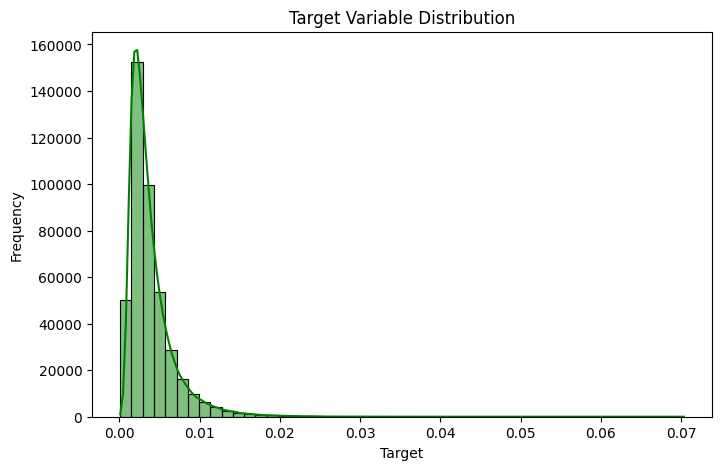

In [30]:
# Visualize Target Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_train['target'], kde=True, bins=50, color='green')
plt.title("Target Variable Distribution")
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.show()

In [33]:
def prepare_data(X_train, X_test):
    print("Initial NaN counts:")
    print(X_train.isnull().sum().sort_values(ascending=False)[:10])
    
    # Forward fill
    X_train = X_train.groupby('stock_id').ffill()
    X_test = X_test.groupby('stock_id').ffill()
    
    print("\nAfter forward fill NaN counts:")
    print(X_train.isnull().sum().sort_values(ascending=False)[:10])
    
    # Backward fill
    X_train = X_train.groupby('stock_id').bfill()
    X_test = X_test.groupby('stock_id').bfill()
    
    print("\nAfter backward fill NaN counts:")
    print(X_train.isnull().sum().sort_values(ascending=False)[:10])
    
    # Handle remaining NaNs with median
    train_medians = X_train.median()
    X_train = X_train.fillna(train_medians)
    X_test = X_test.fillna(train_medians)  # Use train medians for test data
    
    print("\nFinal NaN counts:")
    print(X_train.isnull().sum().sort_values(ascending=False)[:10])
    
    # Convert to float32
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    
    return X_train, X_test

# Apply the function
X_train, X_test = prepare_data(X_train, X_test)

# Verify final results
print("\nVerification:")
print("Train NaN total:", X_train.isnull().sum().sum())
print("Test NaN total:", X_test.isnull().sum().sum())

# If still getting NaNs, identify problematic columns
if X_train.isnull().sum().sum() > 0:
    print("\nColumns still containing NaNs:")
    problem_cols = X_train.columns[X_train.isnull().any()].tolist()
    print(problem_cols)

Initial NaN counts:
size_std_120            9608
log_ret_std_120         9608
order_count_std_120     9608
size_sum_120            3067
order_count_sum_120     3067
size_mean_120           3067
order_count_mean_120    3067
log_ret_std_300          799
order_count_std_300      799
size_std_300             799
dtype: int64


C:\Users\asus\AppData\Local\Temp\ipykernel_31804\3936010417.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_train = X_train.groupby('stock_id').ffill()
C:\Users\asus\AppData\Local\Temp\ipykernel_31804\3936010417.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_test = X_test.groupby('stock_id').ffill()



After forward fill NaN counts:
wap1_mean            0
wap1_std             0
wap2_mean            0
wap2_std             0
log_ret1_std         0
log_ret2_std         0
wap_balance_mean     0
wap_balance_std      0
price_spread_mean    0
price_spread_std     0
dtype: int64


KeyError: 'stock_id'

In [35]:
X_test.isnull().sum()

wap1_mean               2
wap1_std                2
wap2_mean               2
wap2_std                2
log_ret1_std            2
                       ..
size_std_120            3
order_count_sum_120     3
order_count_mean_120    3
order_count_std_120     3
stock_id                0
Length: 118, dtype: int64

In [32]:
#target encoding
t_encoder = ce.TargetEncoder()
t_encoder.fit(df_train['stock_id'], df_train['target'])

X_train['stock_id'] = t_encoder.transform(X_train['stock_id'])
X_test['stock_id'] = t_encoder.transform(X_test['stock_id'])

In [33]:
X_train.isnull().sum()

wap1_mean                  0
wap1_std                   0
wap2_mean                  0
wap2_std                   0
log_ret1_std               0
                        ... 
size_std_120            9608
order_count_sum_120     3067
order_count_mean_120    3067
order_count_std_120     9608
stock_id                   0
Length: 118, dtype: int64

In [34]:
X_train.shape

(428932, 118)

In [35]:
#Model Building

In [36]:
# First, let's create our evaluation metric (RMSPE)
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def rmspe_loss(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

In [37]:
# Create folds based on stock_id to prevent leakage
n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)

In [38]:
# Define base models
def get_models():
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': 10000,
        'learning_rate': 0.01,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'n_jobs': -1,
        'random_state': 42
    }
    
    xgb_params = {
        'objective': 'reg:squarederror',
        'n_estimators': 10000,
        'learning_rate': 0.01,
        'max_depth': 7,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': 42,
        'n_jobs': -1
    }
    
    mlp_params = {
        'hidden_layer_sizes': (100, 50),
        'activation': 'relu',
        'solver': 'adam',
        'alpha': 0.0001,
        'learning_rate': 'adaptive',
        'max_iter': 1000,
        'random_state': 42
    }
    
    estimators = [
        ('lgb', LGBMRegressor(**lgb_params)),
        ('xgb', XGBRegressor(**xgb_params)),
        ('mlp', MLPRegressor(**mlp_params))
    ]
    
    final_estimator = Ridge(alpha=1.0)
    
    model = StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=5,
        n_jobs=-1
    )
    
    return model

In [39]:
# Prepare the data
features = [col for col in df_train.columns if col not in ['target', 'stock_id']]
X = df_train[features]
y = df_train['target']
groups = df_train['stock_id']

In [40]:
# Train and validate the model
cv_scores = []
predictions = np.zeros(len(df_test))
oof_predictions = np.zeros(len(df_train))

In [41]:
for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups=groups)):
    print(f'Training fold {fold + 1}')
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train the model
    model = get_models()
    model.fit(X_train, y_train)
    
    # Make predictions
    val_pred = model.predict(X_val)
    oof_predictions[val_idx] = val_pred
    
        # Calculate fold score
    fold_score = rmspe(y_val, val_pred)
    cv_scores.append(fold_score)
    print(f'Fold {fold + 1} RMSPE: {fold_score}')
    
    # Predict test data
    predictions += model.predict(df_test[features]) / n_splits

Training fold 1


ValueError: Input X contains NaN.
MLPRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values